In [112]:
#1단계 import package
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import datetime as dt
import scipy
import missingno as msno 
plt.style.use('seaborn')


train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sampleSubmission.csv')

In [113]:
#classifiaction.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification

데이터 탐색
- datetime - hourly date + timestamp  

- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
-workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds >> 카테고리형
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals << target

#데이터 탐색

In [114]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [115]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [116]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

In [117]:
submission.head()
# count는 train에만 있음 count를 예측해야함

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [118]:
print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [119]:
print(test.shape)
test.head()

#atemp 버리기 !!! corelationshop 0.98 상관관계 왜냐하면 체감온도는 날씨계산식으로 나오기 때문에 온도가 정석.

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [120]:
for col in train.columns: msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (train[col].isnull().sum() / train[col].shape[0])) 
print(msperc)

column:      count	 Percent of NaN value: 0.00%


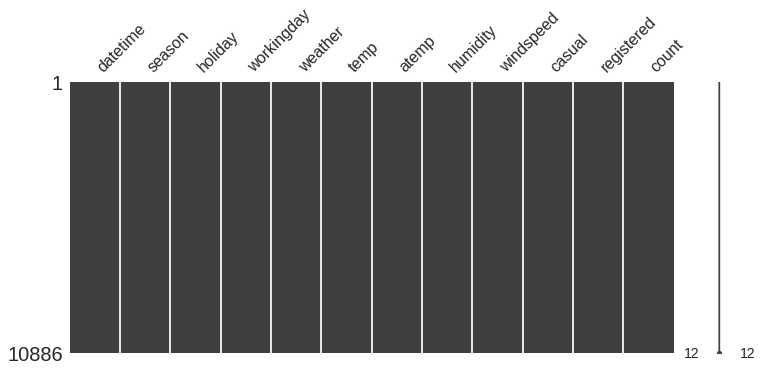

In [121]:
#데이터 변수 결측치 시각화
msno.matrix(train, figsize=(12,5))

#결측치 없음

## Datetime 년 월 일 시간 요일로 해체하기

In [122]:
#datetime 컬럼 문자열 datetime으로 변경해야함...
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [123]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [124]:
#년,월,일,시간,요일 추출
train['year']=train['datetime'].dt.year # 년도 추출 
train['month']=train['datetime'].dt.month # 월도 추출 
train['day']=train['datetime'].dt.day # 일 추출 
train['hour']=train['datetime'].dt.hour # 시 추출 
train['dayofweek']=train['datetime'].dt.dayofweek #요일 추출 , 월요일:0, 일요일:6

In [125]:
#불필요한 컬럼 드랍
#datatime object+ 위에서 따로 추출해내서 필요없음 
train.drop(["datetime"], axis = 1, inplace = True)

In [126]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


In [127]:
test['year']=test['datetime'].dt.year # 년도 추출 
test['month']=test['datetime'].dt.month # 월도 추출 
test['day']=test['datetime'].dt.day # 일 추출 
test['hour']=test['datetime'].dt.hour # 시 추출 
test['dayofweek']=test['datetime'].dt.dayofweek #요일 추출 , 월요일:0, 일요일:6

In [128]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,3


In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


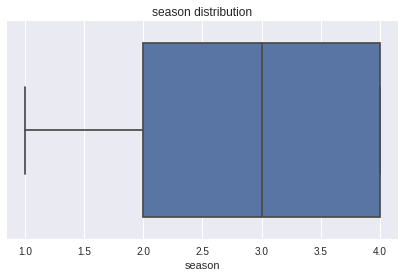

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


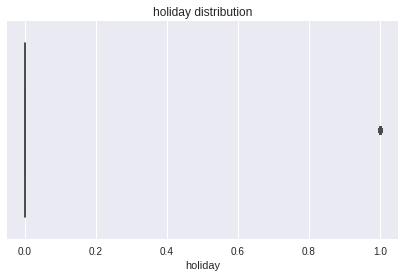

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


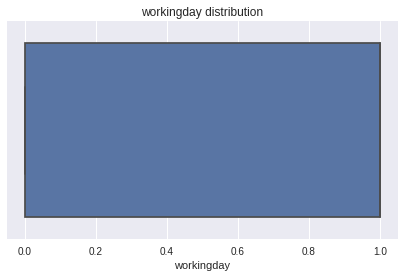

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


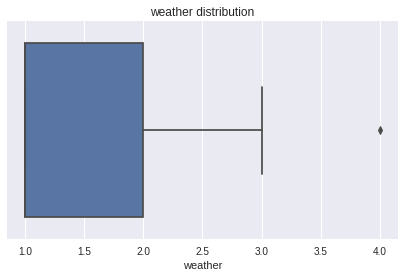

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


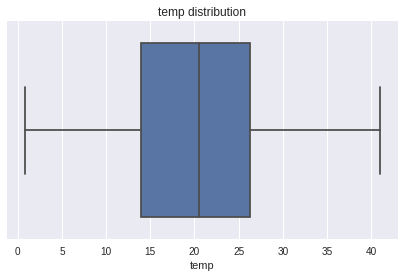

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


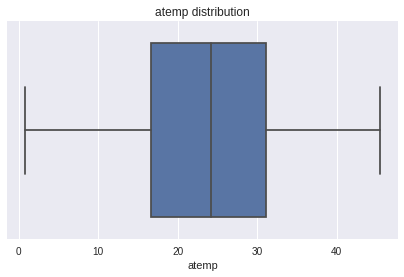

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


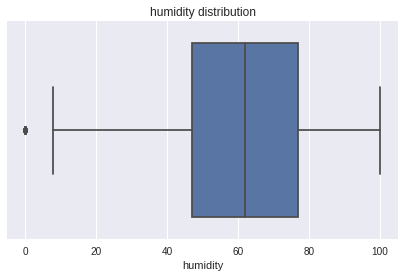

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


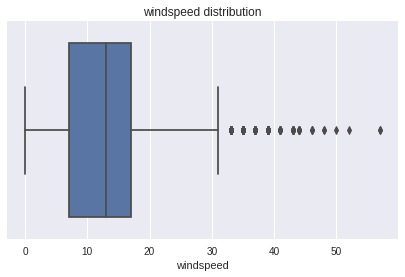

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


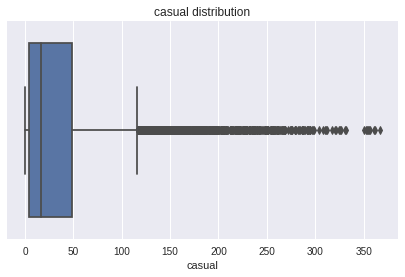

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


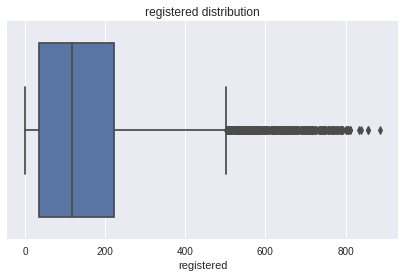

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


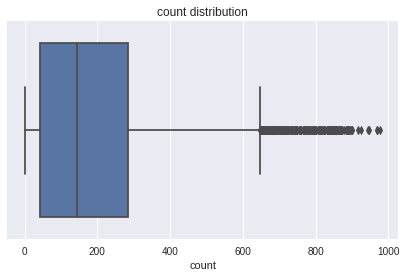

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


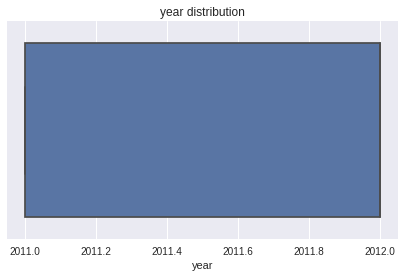

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


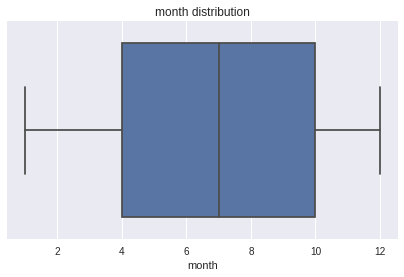

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


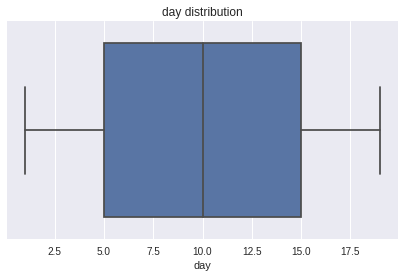

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


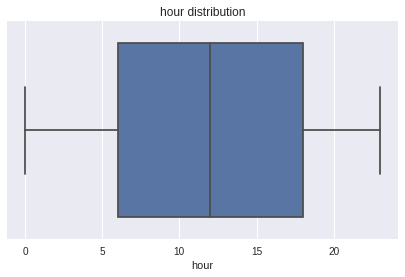

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


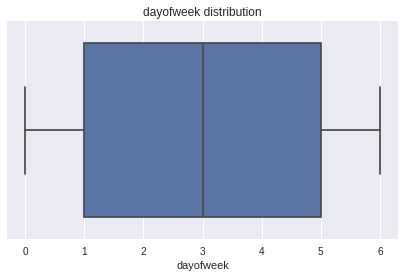

In [130]:
for column in train.columns:
  plt.figure(figsize = (7,4))
  sns.boxplot(train[column])
  plt.title("{} distribution".format(column))
  plt.show()

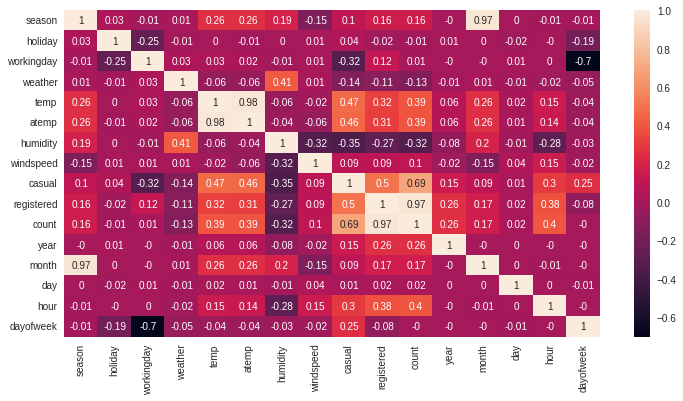

In [131]:
#상관계수 확인

plt.figure(figsize = (12,6))
corr_mat = train.corr().round(2)
sns.heatmap(data = corr_mat, annot = True)

#atemp 버리기 -> temp와 corelationshop 0.98정도의 상관관계 
#온도가 아니라 체감온도 버리는 이유: 체감온도는 날씨계산식으로 추출되기 때문에 온도가 정석의 기준점.

##데이터 전처리

In [132]:

# 이상치 확인하기 : windspeed를 살릴지 말지 고민
q1 = train["windspeed"].quantile(0.25)
q3 = train["windspeed"].quantile(0.75)
iqr = q3 -q1
n = (train.windspeed < q1 - (1.5 * iqr)) | (train.windspeed > q3 + (1.5 * iqr))
train[n]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
175,1,0,0,1,8.20,8.335,32,32.9975,12,83,95,2011,1,8,14,5
178,1,0,0,1,6.56,6.060,37,36.9974,5,64,69,2011,1,8,17,5
194,1,0,0,1,4.92,3.790,46,35.0008,0,19,19,2011,1,9,9,6
196,1,0,0,1,6.56,6.060,40,35.0008,2,47,49,2011,1,9,11,6
265,1,0,1,1,8.20,7.575,47,39.0007,3,52,55,2011,1,12,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,4,0,1,2,16.40,20.455,40,32.9975,63,199,262,2012,11,2,14,4
10154,4,0,1,1,16.40,20.455,24,32.9975,33,202,235,2012,11,8,12,3
10263,4,0,1,3,18.04,21.970,88,43.0006,0,5,5,2012,11,13,1,1
10540,4,0,1,1,19.68,23.485,33,32.9975,39,179,218,2012,12,5,14,2


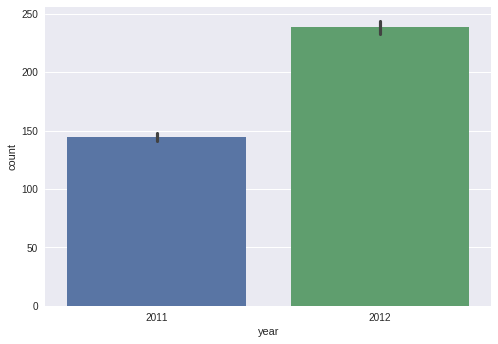

In [133]:
#년도별 자전거 수요량
sns.barplot(data = train, x = 'year', y = 'count')


2012년에 수요량 증가.
-> 단 두개의 year만 비교가능하기때문에 수요가 앞으로도 지속증가하는지에 대한 여부는 알 수 없음, 


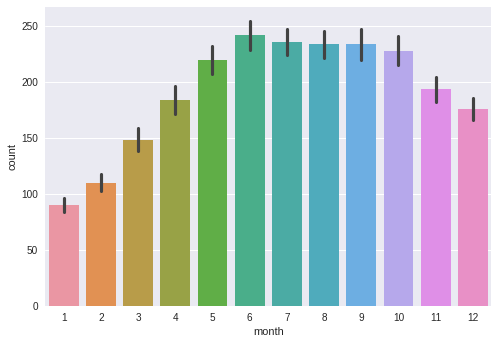

In [134]:
#월별 자전거 수요량
sns.barplot(data = train, x = 'month', y = 'count')

비교적 12, 1, 2월에 자전거 수요량이 적음 -> 추운기온, 겨울
6, 7, 8,9월에 자전거 수요량이 가장 많음 -> 따듯한기온,여름

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_

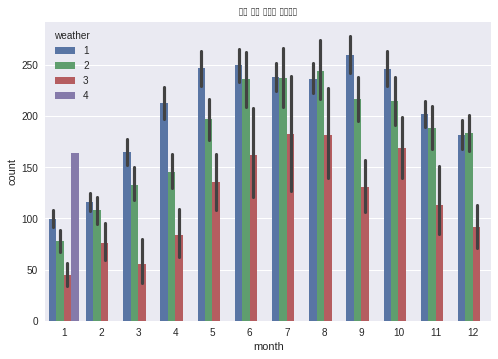

In [135]:
sns.barplot(x="month", y="count", hue="weather", data=train)
plt.title("월과 날씨 이용률 상관관계")
plt.show()

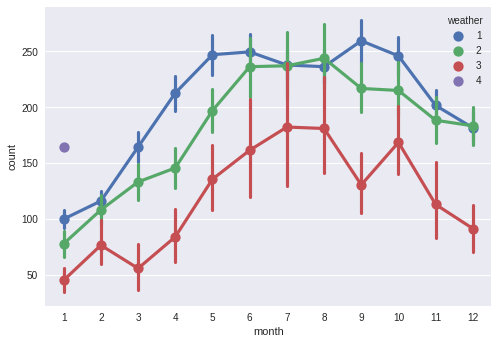

In [136]:

sns.pointplot(data = train, x = 'month', y = 'count', hue ='weather')

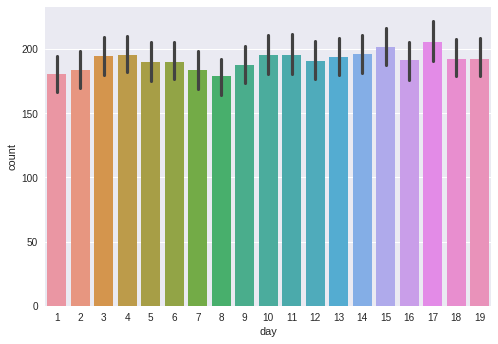

In [137]:
#일별 자전거 수요량
sns.barplot(data = train, x = 'day', y = 'count')

day별로 명백한 차이가 없음 

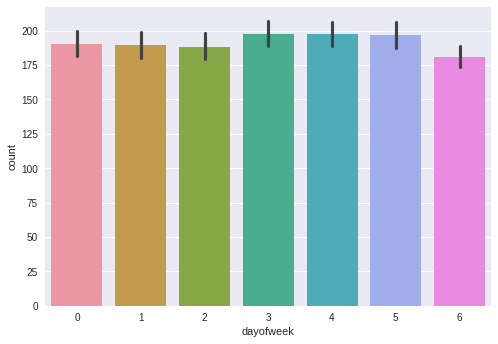

In [138]:
#요일별 자전거 수요량
sns.barplot(data = train, x = 'dayofweek', y = 'count')
#주말이나 주중이나 요일별로 특별한 차이가 없음

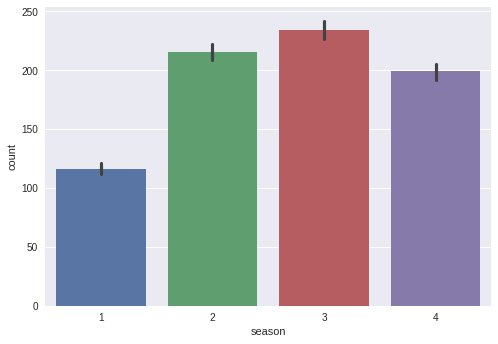

In [139]:
#계절별 자전거 수요량
sns.barplot(data = train, x = 'season', y = 'count')

월별로 출력했을 때 분명, 12,1,2월(겨울)에 가장 수요량이 적었는데, 

위 season 그래프와는 다르게 나왔다. 

따라서 season을 나누는 경계가 다름을 알 수 있었다.

In [140]:
#season이 월별로 123 / 456 /789 /101112 로 나눠짐...
print(train[train['season'] == 1].month.unique())
print(train[train['season'] == 2].month.unique())
print(train[train['season'] == 3].month.unique())
print(train[train['season'] == 4].month.unique())

[1 2 3]
[4 5 6]
[7 8 9]
[10 11 12]


In [141]:
# 날씨와 count의 상관관계 확인 전, season을 올바른 데이터로 바꿔주기
# 워싱턴 D.C의 평균 기온 자료에 기반하여 세계절씩 봄/여름/가을/겨울로 나눈다.

# 계절 분류
def change_season(month):
  if month in [12,1,2]:
    return 4
  elif month in [3,4,5]:
    return 1
  elif month in [6,7,8]:
    return 2
  else:
    return 3
train['season'] = train.month.apply(change_season)

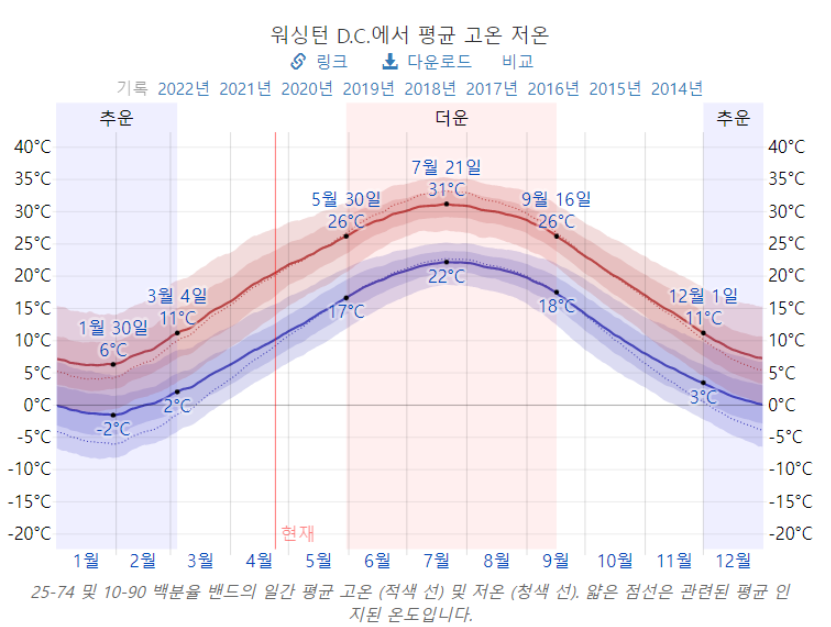

In [142]:
# 날씨와 count의 상관관계 확인 전, season을 올바른 데이터로 바꿔주기
# 워싱턴 D.C의 평균 기온 자료에 기반하여 세계절씩 봄/여름/가을/겨울로 나눈다.

# 계절 분류
def change_season(month):
  if month in [12,1,2]:
    return 4
  elif month in [3,4,5]:
    return 1
  elif month in [6,7,8]:
    return 2
  else:
    return 3
test['season'] = test.month.apply(change_season)

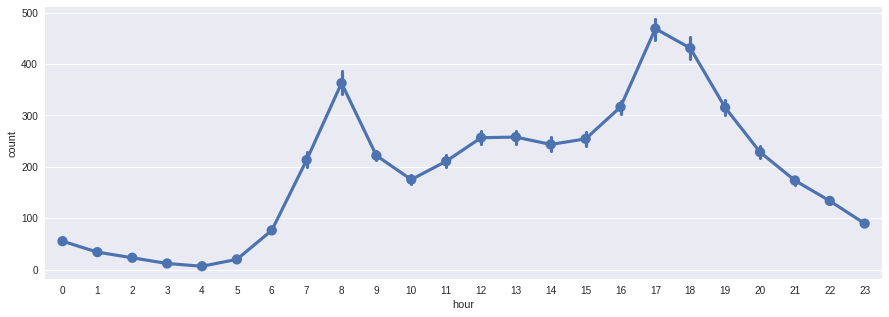

In [143]:
#시간대별 point plot

fig =plt.figure(figsize=(15,5))
sns.pointplot(data = train, x = 'hour', y = 'count') #ax = ax1

시간대별로 보았을때, 
8시 , 17시경에 가장 자전거 수요량이 많다. (출, 퇴근시간임을 알 수 있다.)

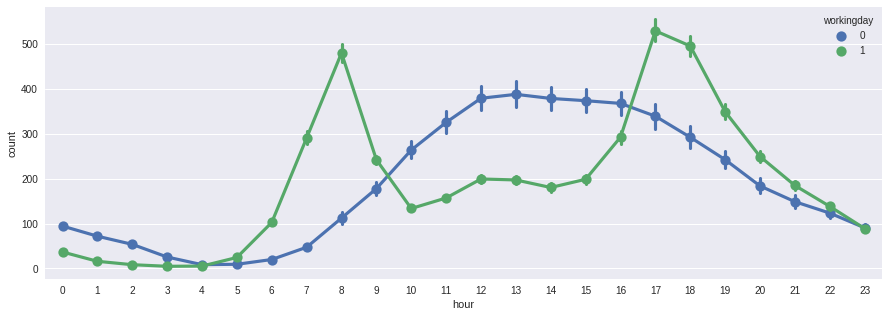

In [144]:
#workingday + 시간대별 point plot

#seaborn에서 카테고리형 데이터를 고려한 그래프를 출력하고 싶으면, hue변수를 추가
fig =plt.figure(figsize=(15,5))
sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'workingday')

1: 근무일 / 0: 근무일 아닐 때

근무일에는 출퇴근 시간에 수요량이 급증하고, 
근무일이 아닐 때에는 오후 낮 시간대에 수요량이 증가

따라서 holiday 변수도 예측에 영향을 줄 것이나 workingday 그래프와 비슷한 양상을 보일것이라고 예측

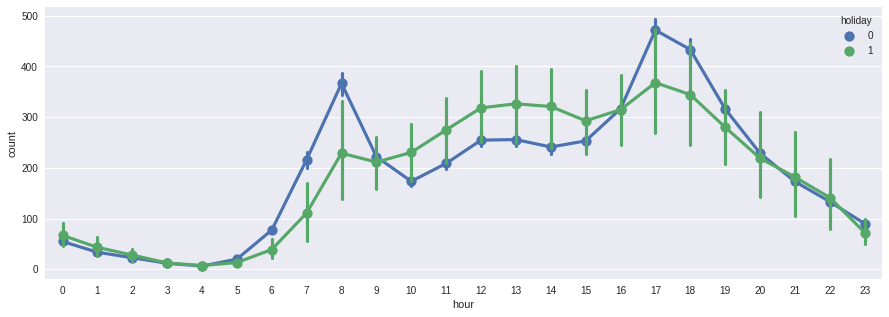

In [145]:
#holiday+시간대별 = 위에 workingday+시간대별 그래프와 유의미한 차이가 없다

fig =plt.figure(figsize=(15,5))
sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'holiday')

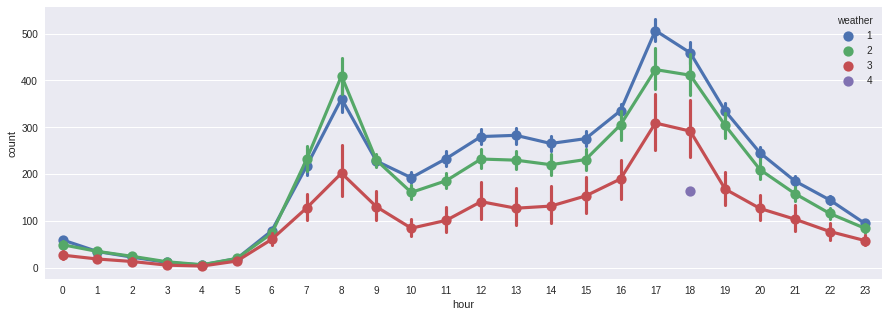

In [146]:
#weather + 시간대별

fig =plt.figure(figsize=(15,5))
sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'weather')

아주깨끗한날씨(1) 약간의 안개와 구름(2) 약간의 눈,비(3) 아주많은비와 우박(4)
1,2번날씨 > 3번날씨 > 4번날씨는 데이터가 거의 없음

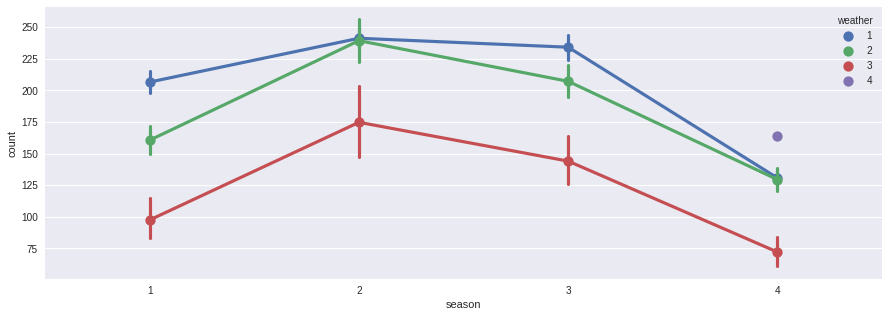

In [147]:
#계절과 날씨를 비교해보면 weather4 데이터(우박)는 겨울인 season4에 나타남 
fig =plt.figure(figsize=(15,5))
sns.pointplot(data = train, x = 'season', y = 'count', hue = 'weather')

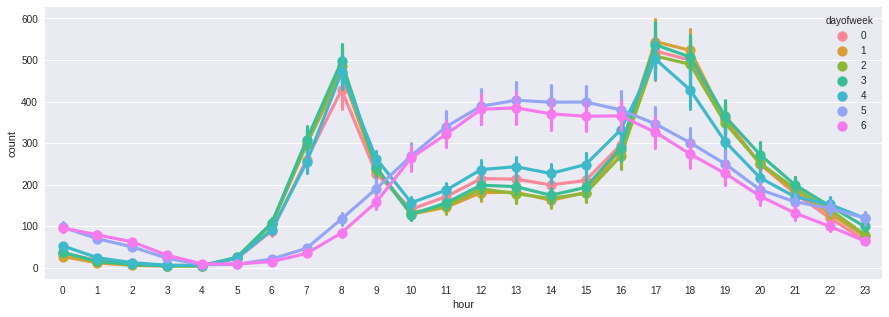

In [148]:
#dayofweek (요일) 와 시간대별

fig =plt.figure(figsize=(15,5))
sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'dayofweek')

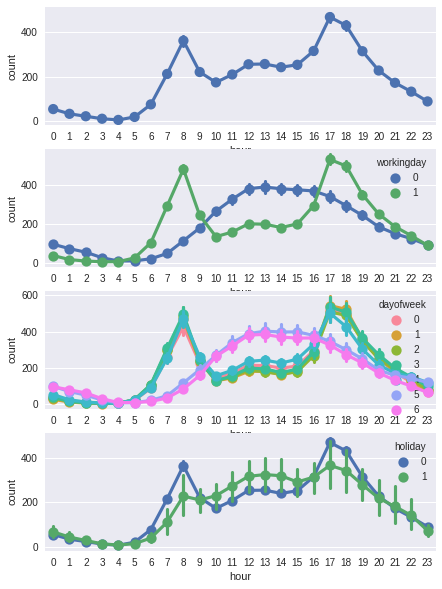

In [149]:
# hour vs workingday vs dayofweek vs holiday -> 시간대를 x축으로 수요량 비교
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4)
fig.set_size_inches(7,10)

sns.pointplot(data = train, x = "hour", y = "count", ax = ax1)
#시간대별로 수요량 보면, notworkingday/주말/holiday일때의 낮시간 수요량이 나타나지 않음 
#즉, 주말(토,일) 그리고 holiday, notworkingday의 표본량이 적음 =전체 수요량 보면 평일(5)일간의 수요량이 대표적으로 나타남)
sns.pointplot(data = train, x = "hour", y = "count", hue = "workingday", ax = ax2)
sns.pointplot(data = train, x = "hour", y = "count", hue = "dayofweek", ax = ax3)
sns.pointplot(data = train, x = "hour", y = "count", hue = "holiday", ax = ax4)

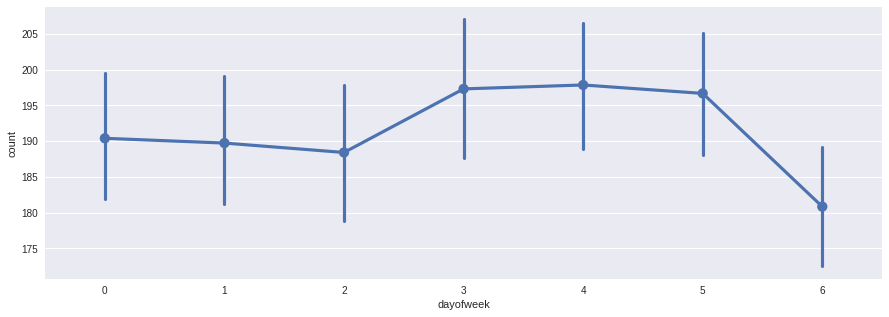

In [150]:
#dayofweek 수요량 poitplot
fig =plt.figure(figsize=(15,5))
sns.pointplot(data = train, x = 'dayofweek', y = 'count')

dayofweek 의 모든 양상은 비슷하게 나타남.... 


In [151]:
#dayofweek 요일범주별 수요량 갯수
train['dayofweek'].value_counts()

5    1584
6    1579
3    1553
0    1551
2    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Rental amount by hour')]

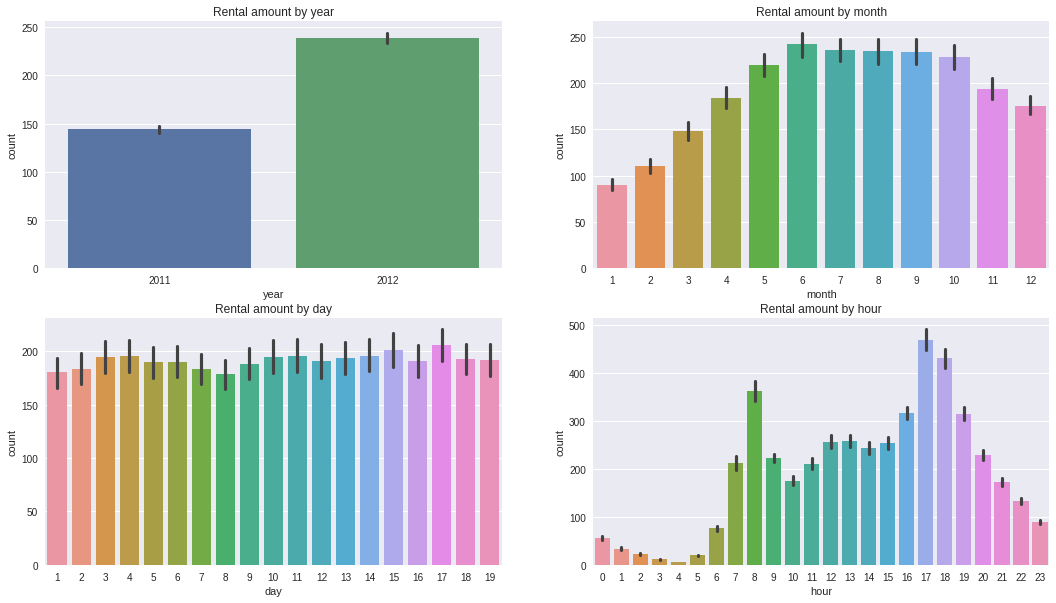

In [152]:
#년,월,일,시간 별 수요량 한눈에 살펴보기
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows = 2, ncols = 2)
figure.set_size_inches(18,10) 
sns.barplot(data=train, x = "year", y = "count", ax = ax1)
sns.barplot(data=train, x = "month", y = "count", ax = ax2) 
sns.barplot(data=train, x = "day", y = "count", ax = ax3) 
sns.barplot(data=train, x = "hour", y = "count", ax = ax4) 

ax1.set(ylabel = "count", title = "Rental amount by year") 
ax2.set(ylabel = "count", title = "Rental amount by month") 
ax3.set(ylabel = "count", title = "Rental amount by day") 
ax4.set(ylabel = "count", title = "Rental amount by hour")



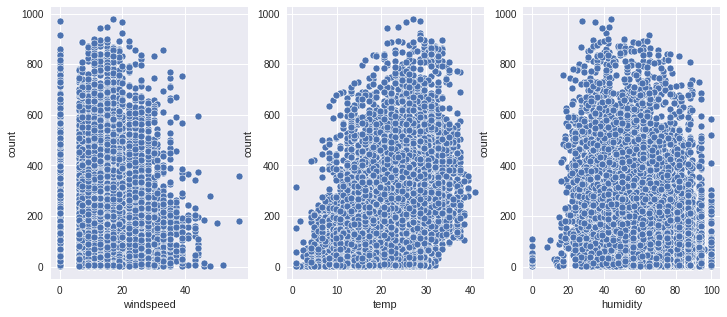

In [153]:
#온도, 습도, 바람세기
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(12,5))

sns.scatterplot(data = train, x = 'windspeed', y = 'count', ax = ax1)
sns.scatterplot(data = train, x = 'temp', y = 'count', ax = ax2)
sns.scatterplot(data = train, x = 'humidity', y =  'count', ax = ax3)

#바람세기가 0..???????

In [154]:
#바람세기가 0인 값 측정
len(train[train['windspeed']==0])
# 결과 : 1313

1313

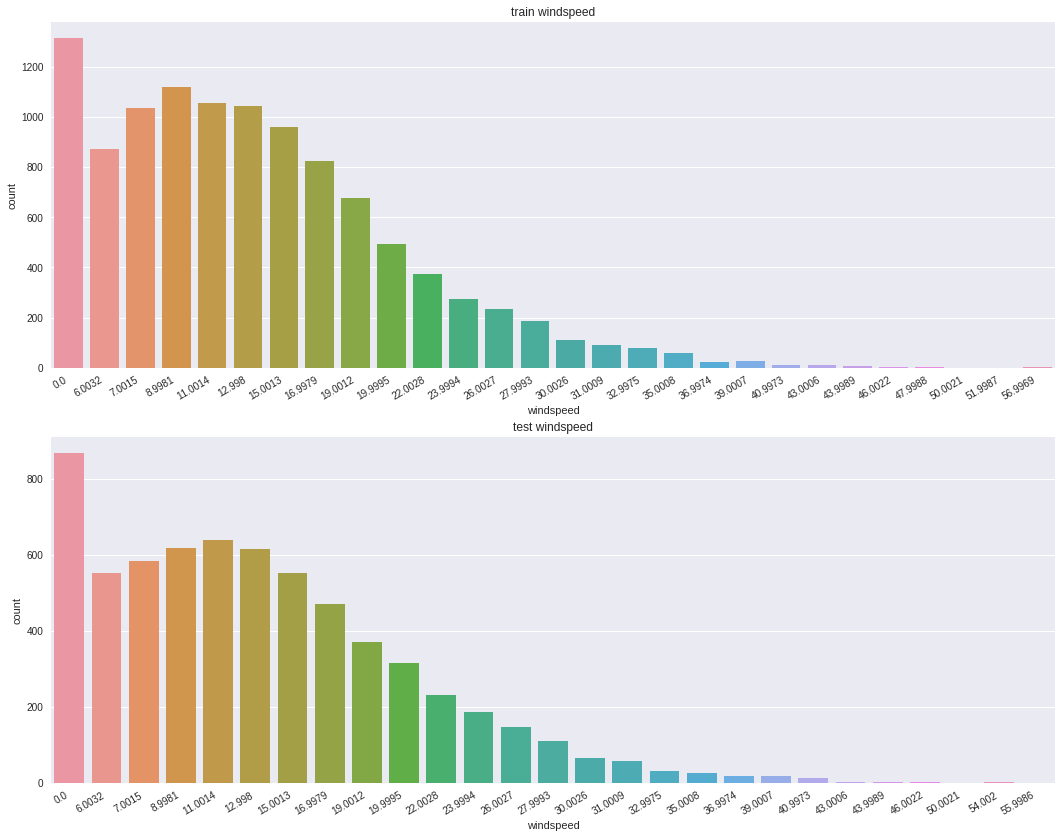

In [155]:
fig, axes = plt.subplots(nrows = 2, figsize = (18,14)) 
plt.sca(axes[0]) 
plt.xticks(rotation = 30, ha = "right") 
axes[0].set(ylabel = "count", title = "train windspeed") 
sns.countplot(data = train, x = "windspeed", ax = axes[0]) 

plt.sca(axes[1]) 
plt.xticks(rotation = 30, ha = "right") 
axes[1].set(ylabel = "count", title = "test windspeed") 
sns.countplot(data = test, x = "windspeed", ax = axes[1])

바람세기 0 인걸 대체해야함
#Feature engineering
이상치 제거

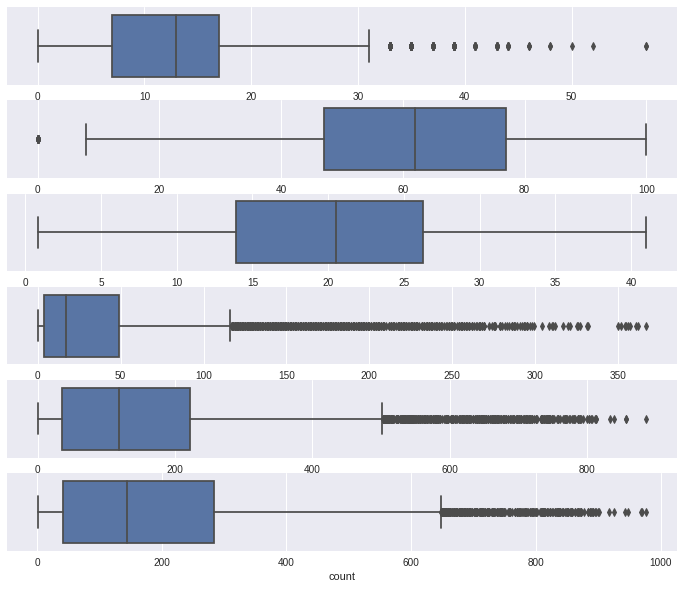

In [156]:
#연속형 변수 이상치 제거
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (12,10))
sns.boxplot(data = train, x = 'windspeed', ax = ax1)
sns.boxplot(data = train, x = 'humidity', ax = ax2)
sns.boxplot(data = train, x = 'temp', ax = ax3)
sns.boxplot(data = train, x = 'casual', ax = ax4)
sns.boxplot(data = train, x = 'registered', ax = ax5)
sns.boxplot(data = train, x = 'count', ax = ax6)

#iQR 방식을 사용한 이상치 제거
전체 데이터를 오름차순으로 정리한 후, 정확히 4등분한다. (25%, 50%, 75%, 100%) 

75%지점값 - 25%지점값의 = iQR

그외 이상과 이하에 해당하는 값 = 이상치

In [157]:
from collections import Counter 

def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers
        
Outliers_to_drop = detect_outliers(train, 2, ["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"])

In [158]:
train.shape

(10886, 16)

In [159]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop = True)
train.shape

(10846, 16)

....................40정도 지워짐.......

# 왜도 첨도 확인

왜도0 첨도3
데이터의 분포가 한쪽으로 쏠린것을 의미
skew의 수치가 -2~+2 정도가 되어야 치우침이 없는 데이터
-2이하는 왼쪽으로 쏠린 데이터 (negative) +2 이상은 오른쪽으로 쏠린 데이터(positive)
positive일경우 변환방법 : square root, cube, log(밑10)
negative일경우 변환방법 : square, cube root, logarithmic(밑2인log)
첨도
분포의 뾰족함이나 평평함에 관련된 것이 아니라 분포의 tail에 대한 모든 것
한쪽 꼬리부분의 극값과 다른쪽 꼬리의 극값과의 차이를 보여줌
아웃라이어를 찾을 때 주로 사용
첨도가 높다 -> 아웃라이어가 많이 있다

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 1.210923
Kurtosis: 1.200871


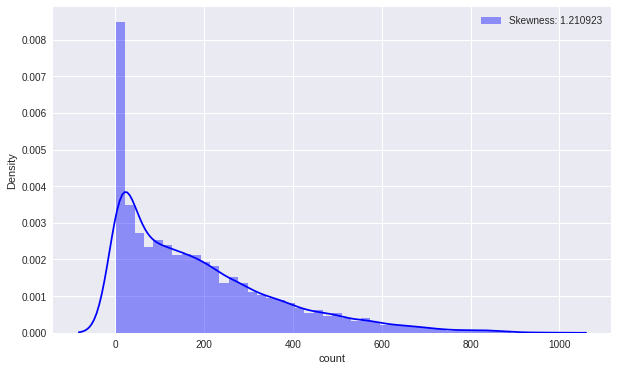

In [160]:
#count의 왜도와 첨도 확인
f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(train["count"], color = "b", label="Skewness: {:2f}".format(train["count"].skew()), ax=ax) 
g = g.legend(loc = "best") 

print("Skewness: %f" % train["count"].skew()) 
print("Kurtosis: %f" % train["count"].kurt())


count가 0에 치우쳐짐

In [161]:
train_num = train[["count", "temp", "atemp", "casual", "registered", "humidity", "windspeed"]]

for col in train_num:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(train[col].kurt())  
         )

count           Skewness: 01.21     Kurtosis: 001.20
temp            Skewness: 00.01     Kurtosis: -00.91
atemp           Skewness: -0.10     Kurtosis: -00.85
casual          Skewness: 02.52     Kurtosis: 007.74
registered      Skewness: 01.51     Kurtosis: 002.61
humidity        Skewness: -0.09     Kurtosis: -00.76
windspeed       Skewness: 00.58     Kurtosis: 000.63


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness(왜도): -0.975198
kurtosis(첨도): 0.247435


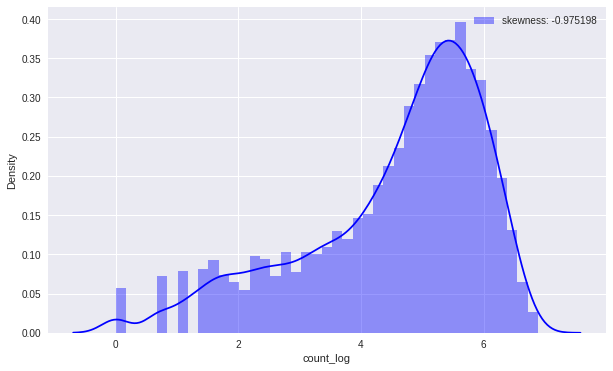

In [162]:
#count log_scalling 으로 정규화
#lambda 를 사용해서 로그를 취해준 count값을 count_log 컬럼으로 생성
train['count_log'] = train['count'].map(lambda i:np.log(i) if i > 0 else 0)

fig, ax = plt.subplots(1,1, figsize = (10, 6))
graph = sns.distplot(train['count_log']
			, color = 'b'
            , label = 'skewness: {:2f}'.format(train['count_log'].skew())
            , ax = ax)
graph = graph.legend(loc = 'best')

print("skewness(왜도): %f" %train['count_log'].skew())
print("kurtosis(첨도): %f" %train['count_log'].kurt())

#필요없는 count값 없애주기
train.drop('count', axis = 1, inplace = True)

변수들의 크기 차이에 민감한 모델을 사용한다면 Scaling 
타겟변수 count 에만 Log를 취함
왜도와 첨도의 수치도 정규화
데이터가 0 하나에만 치우쳐져 있는 것이 개선된 것을 확인

앞으로는 count_log 값을 예측에 활용해야함



In [163]:
# 카운트 값 이상치 삭제 Ver.2
#trainWithtoutOutlier = train[np.abs(train["count"]-train["count"].mean()) <=(3*train["count"].std())]

#print ("Shape Of The Before Ouliers: ",train.shape)
#print ("Shape Of The After Ouliers: ",trainWithtoutOutlier.shape) # 145개 제거


#windspeed 0값 개선
풍속은 상식적으로 아예 0으로 관측되기 어려움
조금만 바람이 불어도 0,01로는 나와야하는거 아닌가
아님 관측이 안돼서 결측치로 0을 넣은 걸수도

<< 결측값 처리 방법>>

- 결측값을 앞 방향 혹은 뒷 방향으로 채우기
- 결측값을 변수별 평균으로 채우기
- 결측값을 가진 데이터를 삭제하기
- 결측값을 0 이나, 아예 다른 값으로 (-999) 대체하기
- 결측값을 예측된 값으로 대체하기 (머신러닝을 돌려서)


(1)선택한 첫번째 방법
 0이 아닌값과 날씨변수로 예측해서 값 채워넣기

windspeed가 null값인 경우를 0으로 처리한 것이라면
결측치를 채우는 방법중 예측된 값으로 대체하는 방법으로 0을 대체

In [164]:
from sklearn.ensemble import RandomForestClassifier
# RandomForest로 값을 예측해
def predict_windspeed(data):
    dataWind0 = data.loc[data["windspeed"] == 0]
    dataWindNot0 = data.loc[data["windspeed"] != 0]
    # 풍속 데이터를 0인 값과 아닌 값들로 나눠준다

    wcol = ["season", "weather", "humidity", "day", "temp", "atemp"]
    # 예측에 필요한 변수들을 지정합니다. 
    # 풍속이 날씨에 대한 변수이기 때문에  날씨에 관련된 변수들을 예측의 독립변수로 지정

    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")
    # 풍속이 0이 아닌 값들을 string데이터로 변환

    rf_wind = RandomForestClassifier()
    rf_wind.fit(dataWindNot0[wcol], dataWindNot0["windspeed"])
    wind0 = rf_wind.predict(X=dataWind0[wcol])
    # 랜덤포레스트를 사용하여 wcol의 변수들로 0인 값들을 학습, 예측
    
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    # 예측한 값을 넣어줄 데이터프레임을 만듦

    predictWind0["windspeed"] = wind0
    # 예측값들을 넣어줌

    data = predictWindNot0.append(predictWind0)
    # 0이 아닌 데이터들과 예측값들을 합쳐줌

    data["windspeed"] = data["windspeed"].astype("float")
    # 풍속의 데이터들을 다시 float 타입으로 변환
    
    data.reset_index(inplace = True)
    data.drop("index", inplace = True, axis = 1)
    
    return data

In [165]:
train = predict_windspeed(train)
test = predict_windspeed(test)

#독립변수 + 0이 아닌 데이터로 분류했던 windspeed를 RandomForest로 학습
#학습시킨 모델을 통해 0 값을 가졌던 windspeed를 예측


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [166]:
train[train['windspeed'] == 0.0]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,year,month,day,hour,dayofweek,count_log


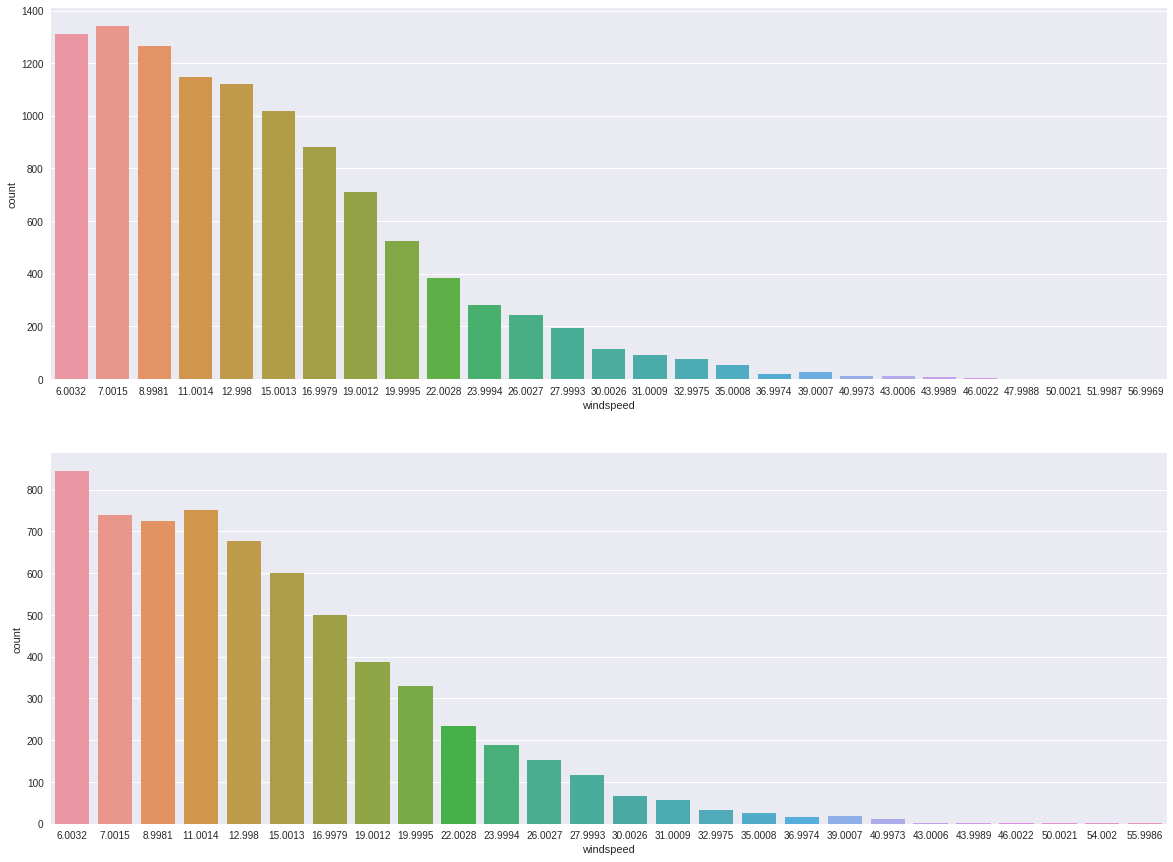

In [167]:
fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_size_inches(20,15)

#갯수를 세야하니 countplot
sns.countplot(data = train, x = 'windspeed', ax = ax1)
sns.countplot(data = test, x = 'windspeed', ax = ax2)

In [168]:
#바람세기가 0이라니
len(train[train['windspeed']==0])
len(test[test['windspeed']==0])

0

##결론

Bike Sharing Demand EDA에서는 뚜렷한 특징을 보이는 Feature

 -시간(hour): 출퇴근 시간인 8시와 17~18시에 대여량이 가장 많다

-요일(dayofweek): 주중에 출퇴근, 주말에는 오후 시간대에 대여량이 많다

-계절(season): 여름. 

-년도(year): 2011<2012



drop:

atemperature (0.98)

holiday, dayofweek (workingday만 가져가기)


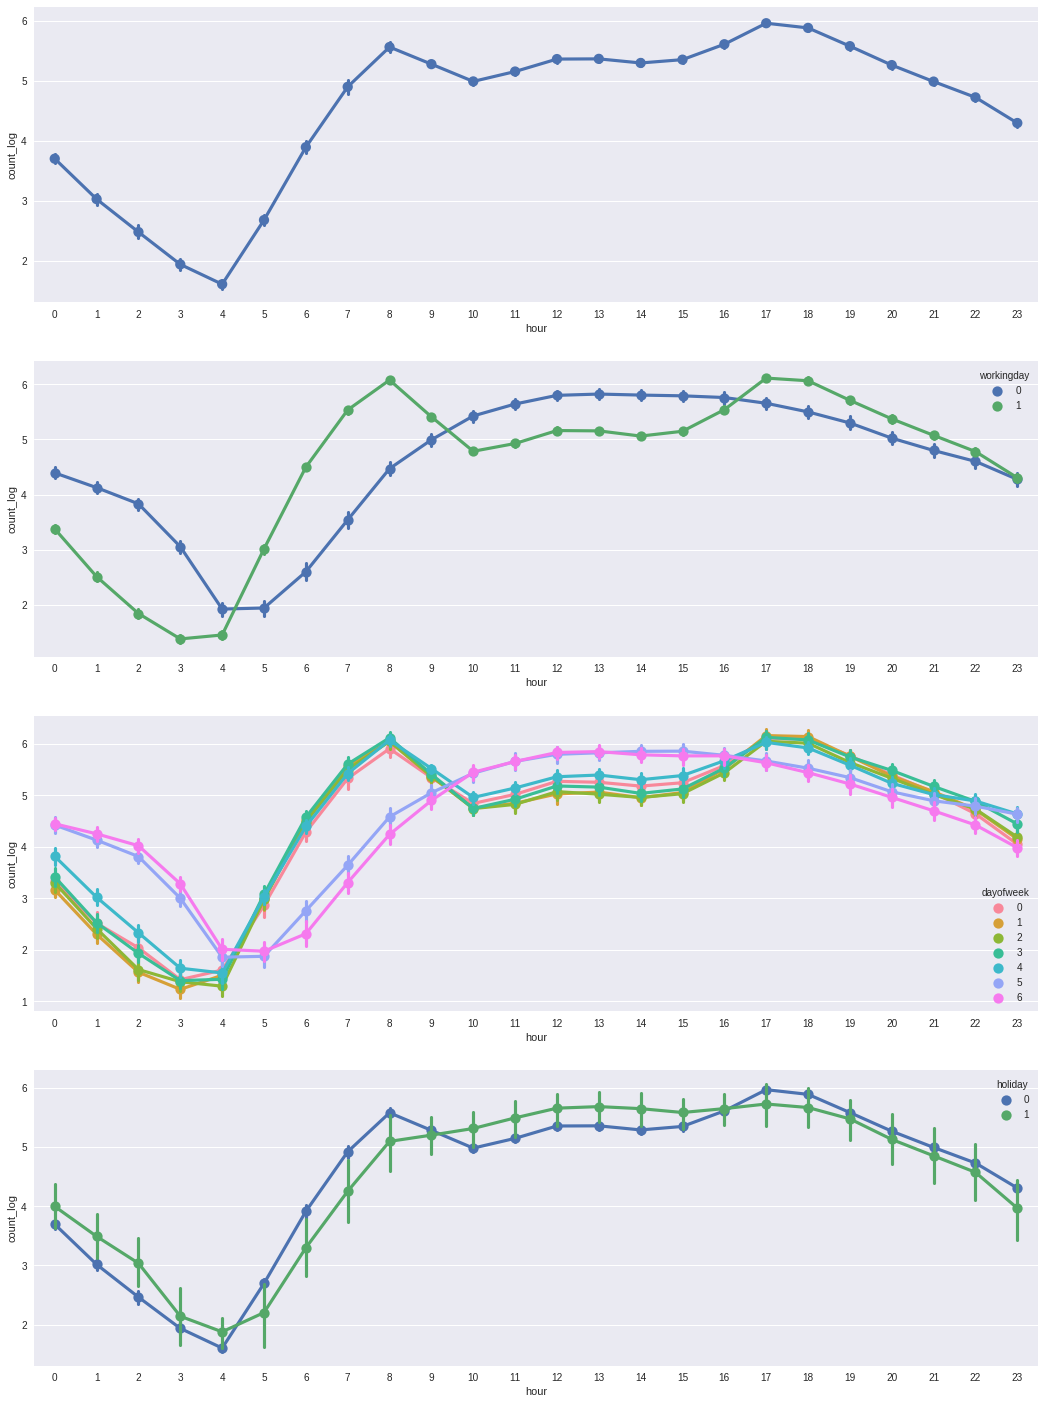

In [170]:
# workingday vs dayofweek vs holiday 비교
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4)
fig.set_size_inches(18,25)

sns.pointplot(data = train, x = "hour", y = "count_log", ax = ax1)
sns.pointplot(data = train, x = "hour", y = "count_log", hue = "workingday", ax = ax2)
sns.pointplot(data = train, x = "hour", y = "count_log", hue = "dayofweek", ax = ax3)
sns.pointplot(data = train, x = "hour", y = "count_log", hue = "holiday", ax = ax4)

#One hot encoding

In [171]:
# One_hot_encoding
train = pd.get_dummies(train, columns = ["weather"], prefix = "weather") 
test = pd.get_dummies(test, columns = ["weather"], prefix = "weather") 
train = pd.get_dummies(train, columns = ["season"], prefix = "season") 
test = pd.get_dummies(test, columns = ["season"], prefix = "season")

## 왜 workingday 넣지 않았는지
## 어차피 1과 0으로 true / false 의미기에 해도 의미가 없다고 판단함 

#Modeling 전 변수 정리 (drop 실행)

In [172]:
#train에 사용될 변수

#submission의 형태를 살펴보았을 때, datetime을 기준으로 예측값을 적엇다.
#따라서 test의 datetime은 미래의 submission 을 위해서 따로 저장해두기로 한다.
test_datetime = test['datetime']

train.drop(['atemp', 'holiday','dayofweek'], axis = 1, inplace = True)
test.drop(['atemp', 'holiday','dayofweek'], axis = 1, inplace = True) 

In [ ]:
train.columns

In [ ]:
train.info()
#-범주형 데이터 int64 category로 변경해야 하나?
#feature_names=['season','holiday','workingday','weather','temp','atemp',
              #'humidity','windspeed','year','hour','dayofweek']

#-수리형을 범주형으로 바꿔주는 for 문 
#c_f_n =['season','holiday','workingday','weather',
        #'year','hour','dayofweek','month']

#for v in c_f_n:
    #-dtype이 int64라서 category로 변경
    #train[v]=train[v].astype("category")
    #test[v]=train[v].astype("category")
#train.info() #- dtype 변경 확인 

#- 4개의 변수로 되어있음 확인 
#train['season'].dtypes 
#test['season'].dtypes

In [173]:
X = train.drop('count_log', axis = 1)
y = train['count_log']

In [174]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


NameError: ignored

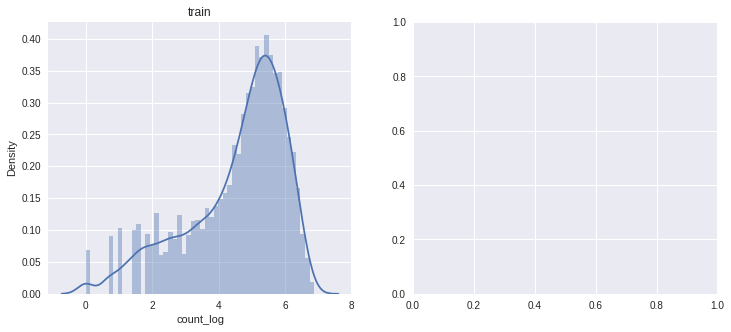

In [175]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

##모델링- 시도(1) rmsle 안쓰고 돌리기 (실패)

In [176]:
#선형회귀

# 1. 모델 생성
lin_reg = LinearRegression()
# 2. 모델 훈련
lin_reg.fit(X_train, y_train) # 훈련 데이터 with 정답 
# 3. 예측
# predict = lin_reg.predict(X_test) # 테스트 데이터에 대한 예측
# 4. 평가
lin_reg.score(X_test, y_test) # R2 Score 반환

0.7350974923805693

In [177]:
# 경사하강법

from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(random_state=42)
sgd_reg.fit(X_train, y_train)
# predict = sgd_reg.predict(X_test)
sgd_reg.score(X_test, y_test)

-7.097327230679004e+29

In [178]:
#릿지, 라쏘, 엘라스틱넷

from sklearn.linear_model import Ridge, Lasso, ElasticNet

ridge_reg = Ridge(random_state=42)
lasso_reg = Lasso(random_state=42)
elastic_net =ElasticNet(random_state=42)

In [179]:
for reg in [ridge_reg, lasso_reg, elastic_net]:
    reg.fit(X_train, y_train)
    # predict = reg.predict(X_test)
    print(reg.__class__.__name__, reg.score(X_test, y_test))

Ridge 0.7350964761959755
Lasso 0.7142825093074989
ElasticNet 0.7240062157047653


In [180]:
#폴리노미

from sklearn.preprocessing import PolynomialFeatures

# 선형회귀 모델 생성
lin_reg = LinearRegression()

# 다항 특성추가 (by 변환기(PolynomialFeatures()))
poly_features = PolynomialFeatures(degree=2)
X_train_ploy = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# 모델 훈련
lin_reg.fit(X_train_ploy, y_train)
# 평가
lin_reg.score(X_test_poly, y_test)

0.8734586609761038

In [181]:
# 앙상블 GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor(n_estimators = 2000
					, learning_rate = 0.05
                                    , max_depth = 5
                                    , min_samples_leaf = 10
                                    , min_samples_split = 7
                                    , random_state = 42)
#model.fit(x, y)
regressor.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=10,
                          min_samples_split=7, n_estimators=2000,
                          random_state=42)

In [182]:
score_train = regressor.score(X_train, y_train)
score_test = regressor.score(X_test, y_test)

print("train score: %f" %score_train)
print("test score: %f" %score_test)
#과대적합

train score: 0.999992
test score: 0.999923


##모델링 -시도(2) rmsle 만들어서 돌리기


In [187]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

In [202]:
#6 주영님
#https://github.com/BaekKyunShin/Kaggle/blob/master/Bike_Sharing_Demand/Bike%20Sharing%20Demand%20by%20Random%20Forest.ipynb
from sklearn.metrics import make_scorer
def RMSLE(predicted_values, actual_values):
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score
    
RMSLE_scorer = make_scorer(RMSLE)
RMSLE_scorer

make_scorer(RMSLE)

In [205]:
 #선형회귀 모델
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', category=DeprecationWarning)

# 선형회귀 모델을 초기화
linear_model = LinearRegression()

# 모델 학습
y_train_log = np.log1p(y_train)
linear_model.fit(X_train, y_train_log)

# 예측하고 정확도를 평가한다.
preds = linear_model.predict(X_train)
print("RMSLE Value for linear regression: ",
     RMSLE(np.exp(y_train_log), np.exp(preds)))

RMSLE Value for linear regression:  0.17574525595184895


In [206]:
#릿지 모델
ridge_model = Ridge()
ridge_params_ = {'max_iter':[3000],
                 'alpha':[0.01, 0.1, 1, 2, 3, 4, 10,
                          30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_model = GridSearchCV(ridge_model,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_model.fit(X_train, y_train_log)
preds = grid_ridge_model.predict(X_train)
print (grid_ridge_model.best_params_)
print ("RMSLE Value For Ridge Regression: ", 
       RMSLE(np.exp(y_train_log),np.exp(preds)))

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.17574525256938073


In [200]:
lasso_model = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = {'max_iter':[3000], 'alpha':alpha}

grid_lasso_model = GridSearchCV(lasso_model,
                          lasso_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_lasso_model.fit(X_train, y_train_log)
preds = grid_lasso_model.predict(X_train)
print (grid_lasso_model.best_params_)
print ("RMSLE Value For Lasso Regression: ", 
       RMSLE(np.exp(y_train_log),np.exp(preds)))

{'alpha': 0.001, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.17577869555019332


In [215]:
from sklearn.ensemble import RandomForestRegressor
randomforest_model = RandomForestRegressor(n_estimators=150)

y_train_log = np.log1p(y_train)
randomforest_model.fit(X_train, y_train_log)

preds = randomforest_model.predict(X_train)
score_rf = rmsle(np.exp(y_train_log),np.exp(preds))
print ("RMSLE Value For Random Forest: ", score_rf)
predsTest = randomforest_model.predict(X_test)

RMSLE Value For Random Forest:  0.0017096472115451157


In [209]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = RMSLE(np.exp(y_train_log),np.exp(preds))
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.0005129317287611256


In [211]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# K_fold generator 만들기
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
score = cross_val_score(linear_model, X_train, y_train, cv=k_fold, scoring=RMSLE_scorer)
score = score.mean()
# 0과 가까울 수록 좋은 데이터
print("Score = {0:.5f}".format(score))

Score = 0.22308


In [220]:
models = [LinearRegression(), Ridge(), Lasso(), RandomForestRegressor(), GradientBoostingRegressor()]
regressors = ['LinearRegression', 'Ridge', 'Lasso', 'RandomForestRegressor', 'GradientBoostingRegressor']
score_result = []
 
# Kfold 교차 검증
for x in models:
    Rgr = x
    score = cross_val_score(Rgr, X_train, y_train , cv=k_fold, scoring= RMSLE_scorer)
    score_result.append(score.mean())
 
# 결과를 dataframe 으로 변경
Kfold_score_result = pd.DataFrame({'Score' : score_result}, index=regressors)
Kfold_score_result

,Score
LinearRegression,0.223084
Ridge,0.223085
Lasso,0.234385
RandomForestRegressor,0.005208
GradientBoostingRegressor,0.010026


# Train

In [225]:
lasso_model.fit(X_train, y_train)

Lasso()

In [227]:
predictions = lasso_model.predict(X_test)
print(predictions.shape)
predictions[0:10]

(2170,)


array([4.35181462, 5.14199294, 4.18533786, 7.22021874, 4.42922633,
       4.85895828, 5.81984368, 3.13009198, 4.9346919 , 4.73515026])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


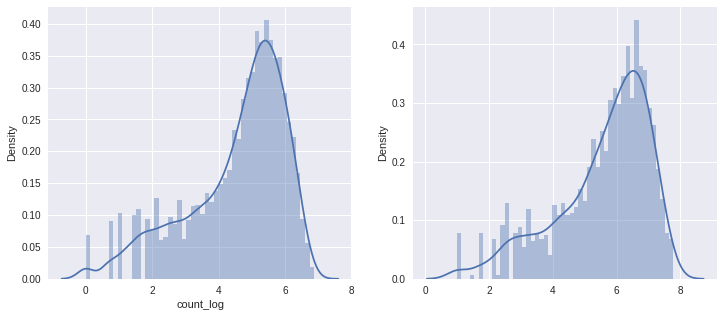

In [203]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [229]:
# submit은 손을 더 보고 하기로 했습니다.

# 전처리를 다르게해서 모델링 해보기

In [ ]:
train.info()
feature_names=['season','holiday','workingday','weather','temp','atemp',
              'humidity','windspeed','year','hour','dayofweek']

# 수리형을 범주형으로 바꿔주는 for 문 
c_f_n =['season','holiday','workingday','weather',
        'year','hour','dayofweek','month']

for v in c_f_n:
    -dtype이 int64라서 category로 변경
    train[v]=train[v].astype("category")
    test[v]=train[v].astype("category")
train.info() #- dtype 변경 확인 

# 4개의 변수로 되어있음 확인 
train['season'].dtypes 
test['season'].dtypes

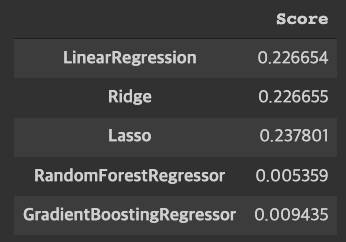